In [1]:
import einops, numpy as np
import torch, os, openslide
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [ ]:
#subject = "14" #6,22,42,27,28,41,10,14,39
#pos_x, pos_y = 5000, 28000
subject, pos_x, pos_y = "28", 5000, 23000
subject, pos_x, pos_y = "41", 5000, 28000
subject, pos_x, pos_y = "22", 5000, 18000

size = (850*16, 850*16)
if os.path.exists(f"<path>/PESO/peso_training/pds_{subject}_HE_training_mask_corrected.tif"):
    gt = openslide.open_slide(f"<path>/PESO/peso_training/pds_{subject}_HE_training_mask_corrected.tif")
else:
    gt = openslide.open_slide(f"<path>/PESO/peso_training/pds_{subject}_HE_training_mask.tif")
gt = gt.read_region((int(pos_x * gt.level_downsamples[1]),
                           int(pos_y * gt.level_downsamples[1])), 1, size)
slide = openslide.open_slide(f"<path>/PESO/peso_training/pds_{subject}_HE.tif")
slide = slide.read_region((int(pos_x * slide.level_downsamples[1]),
                           int(pos_y * slide.level_downsamples[1])), 1, size)
gt = np.array(gt)[:,:,0]
gt = gt == 2
slide = np.array(slide)[:,:,:3]

In [21]:
inset = {
    "14": (6_000,6_000),
    "28": (900,6_000 - 2880),
    "41": (900 + 3500,6_000 + 2000),
    "22": (900 + 3500 + 2*2880,6_000 + 2000 + 2880),
}[subject]

In [ ]:
def dice(pred, gt):
    intersection = np.logical_and(pred, gt).sum()
    return 2 * intersection / (pred.sum() + gt.sum())

In [ ]:
oct_seg = np.load("<path>/qualitative/inference2_peso_oct.npy")

In [ ]:
unet_seg = np.load("<path>/qualitative/patchwise_inference_peso_unet.npy")

In [ ]:
oct_seg.shape, unet_seg.shape

In [ ]:
dice(oct_seg, gt), dice(unet_seg, gt)

In [ ]:
plt.imshow(slide)
unet_seg_w_alpha = np.repeat(unet_seg[:, :, None], 4, axis=2).astype(float)
unet_seg_w_alpha[unet_seg == gt,:3] *= np.array([0, 1, 0]) #TP
unet_seg_w_alpha[unet_seg != gt,:3] *= np.array([1, 0, 0]) #FP


plt.imshow(unet_seg_w_alpha)
PATCH_SIZE = (180*16, 180*16)
for i in range(PATCH_SIZE[0], size[0], PATCH_SIZE[0]):
    for j in range(PATCH_SIZE[1], size[1], PATCH_SIZE[1]):
        plt.axhline(j, color='red')
        plt.axvline(i, color='red')
#plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
plt.xticks([])
plt.yticks([i*PATCH_SIZE[0]/4 for i  in range(5)])
plt.gca().add_patch(plt.Rectangle(tuple(inset), 500, 500, fill=False, edgecolor='blue', lw=2))
inset_ax = inset_axes(plt.gca(),
                    width="30%", # width = 30% of parent_bbox
                    height="30%", # height : 1 inch
                    loc=3)
inset_ax.imshow(slide[inset[0]:inset[0]+500, inset[1]:inset[1]+500])
inset_ax.imshow(unet_seg_w_alpha[inset[0]:inset[0]+500, inset[1]:inset[1]+500])
#inset_ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
inset_ax.set_xticks([])
inset_ax.set_yticks([0,250,500])

plt.savefig("figures/qualitative/unet_peso.png", bbox_inches='tight', pad_inches=0, dpi=300)

In [19]:
def my_plot(seg, name, show_grid=False):
    plt.imshow(slide)
    seg_w_alpha = np.repeat(seg[:, :, None], 4, axis=2).astype(float)
    seg_w_alpha[seg == gt,:3] *= np.array([0, 1, 0]) #TP
    seg_w_alpha[seg != gt,:3] *= np.array([1, 0, 0]) #FP


    plt.imshow(seg_w_alpha)
    PATCH_SIZE = (180*16, 180*16)
    if show_grid:
        for i in range(PATCH_SIZE[0], size[0], PATCH_SIZE[0]):
            for j in range(PATCH_SIZE[1], size[1], PATCH_SIZE[1]):
                plt.axhline(j, color='red')
                plt.axvline(i, color='red')
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    plt.gca().add_patch(plt.Rectangle(tuple(inset), 500, 500, fill=False, edgecolor='blue', lw=2))
    inset_ax = inset_axes(plt.gca(),
                        width="30%", # width = 30% of parent_bbox
                        height="30%", # height : 1 inch
                        loc=3)
    inset_ax.imshow(slide[inset[1]:inset[1]+500, inset[0]:inset[0]+500])
    inset_ax.imshow(seg_w_alpha[inset[1]:inset[1]+500, inset[0]:inset[0]+500])
    inset_ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    return plt.savefig(f"figures/qualitative/{name}.png", bbox_inches='tight', pad_inches=0, dpi=300)

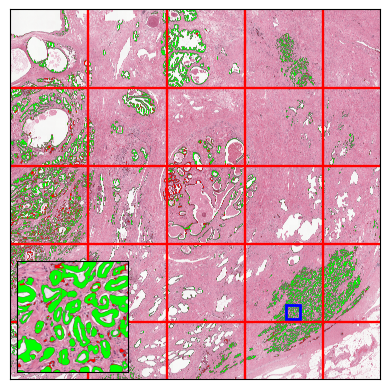

In [22]:
my_plot(unet_seg, f"unet_peso{subject}", show_grid=True)

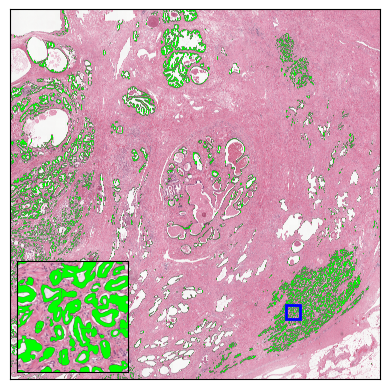

In [24]:
my_plot(gt, f"gt_peso{subject}")

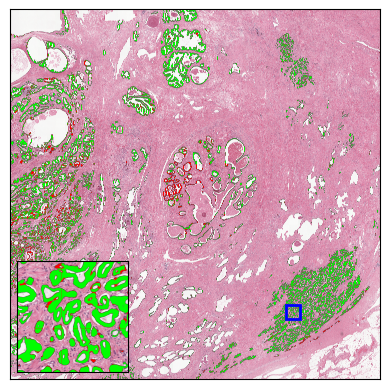

In [23]:
my_plot(oct_seg, f"oct_peso{subject}")

In [ ]:
plt.imshow(slide)
oct_seg_w_alpha = np.repeat(oct_seg[:, :, None], 4, axis=2).astype(float)
oct_seg_w_alpha[oct_seg == gt,:3] *= np.array([0, 1, 0])
oct_seg_w_alpha[oct_seg != gt,:3] *= np.array([1, 0, 0])


plt.imshow(oct_seg_w_alpha)